In [1]:
import numpy as np
import os, sys
import h5py
import pandas as pd
import matplotlib.pyplot as plt

import datetime
#sys.path.append('/Users/ajc/Desktop/SimDataInputs/ats-repo/ats/tools/utils/')
#sys.path.append('/Users/ajc/Projects/ATS-Data/OR-CONDO/mytests-orhydra/PyScript')

sys.path.append('/Users/ajc/Core/SimDataInputs/ats-repo/ats-Aug6/tools/utils/')
sys.path.append('/Users/ajc/Core/PostProcessData/PyScript')
import readdata as rd
import parse_ats, transect_data

In [2]:
# Read Snow
def Observed_EddyCorianceData(file,col_names,year):
    
    data_orig = pd.read_csv(file)#,skiprows=1)
    time1 = np.array([year + t/365. for t in data_orig['DOY']])
    data1 = np.array([ x for x in data_orig[col_names[1]]])
   
    dat_temp = np.zeros((len(time1)))
    
    for i,d in enumerate(data1):
        if d>0:
            dat_temp[i] = d
        
    L1 = len(time1) - len(time1)%48
    
    Data1 = np.reshape(dat_temp[:L1], (-1,48)).mean(axis=1)
    Time1 = np.reshape(time1[:L1], (-1,48)).mean(axis=1)
    
    mask = np.ones(len(Data1),dtype=bool)
    
    for i,d1 in enumerate(Data1):
        if d1 == 0:
            mask[i] = False

    Data1 = Data1[mask] * 24.
    Time1 = Time1[mask]
   
    Data = dict()
    Data['DOY'] = Time1
    Data[col_names[1]] = Data1 
    return Data

In [3]:
#%matplotlib
infile = '/Users/ajc/Core/SimDataInputs/observed_data_barrow/eddy_covariance/'
infile = [infile + 'NGEE_Barrow_EC_%s_data.csv'%i for i in range(2012,2015)]

ObservedET_Orig = dict()
years = [2012,2013,2014]
for i,file in enumerate(infile):
    print (file)
    d = Observed_EddyCorianceData(file,col_names=['date', 'ET'],year=years[i]);
    ObservedET_Orig['ET_%s'%years[i]] = d['ET']
    ObservedET_Orig['Time_%s'%years[i]] = d['DOY']
#print (ObservedET_Orig.keys())

ObservedET = dict()
#plt.plot(ObservedET_Orig['Time_2012'],ObservedET_Orig['ET_2012'])
ObservedET['Time'] = np.concatenate([ObservedET_Orig[key] for key in ObservedET_Orig.keys() if 'Time' in key])
ObservedET['ET'] = np.concatenate([ObservedET_Orig[key] for key in ObservedET_Orig.keys() if 'ET' in key])

/Users/ajc/Core/SimDataInputs/observed_data_barrow/eddy_covariance/NGEE_Barrow_EC_2012_data.csv
/Users/ajc/Core/SimDataInputs/observed_data_barrow/eddy_covariance/NGEE_Barrow_EC_2013_data.csv
/Users/ajc/Core/SimDataInputs/observed_data_barrow/eddy_covariance/NGEE_Barrow_EC_2014_data.csv


In [4]:
#print (len(ObservedET['Time']),len(ObservedET_Orig['Time_2012']),len(ObservedET_Orig['Time_2013']),len(ObservedET_Orig['Time_2014']))
#print (ObservedET['Time'][50:70])
#plt.plot(ObservedET['Time'],ObservedET['ET'], '.')

In [5]:
import re
def sorted_nicely( l ):
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)


In [7]:
simulation = ['SiteC_3D_3R1E', 'SiteC_3D_3R1E'] # Evaporation comparison
#simulation = ['SiteC_3D_3R1E', 'SiteC_3D_3R1G'] # Evaporation comparison, dessicated zone = 20 cm
path = "/Users/ajc/Core/Projects/ATS-Data/OR-CONDO/simulations/barrow_icewedges/NGEE/SiteC_3D_June10/"

dir_files = os.listdir(path + simulation[0])
Vars = ['surface-evaporation-center', 'surface-evaporation-rightrim', 'surface-evaporation-righttrough']
SimName = ['S1', 'S2']
Files = dict()
for var in Vars:
    Files_Temp = [f for f in dir_files if f.startswith(var)]
    Files[var] = sorted_nicely(Files_Temp)


In [8]:
DataSimAll= dict()

temp_C = []
for i,sim in enumerate(simulation):
    Sname = SimName[i] + '-'
    for var in Vars:
        for files in Files[var]:
            dat = rd.ReadSingleFile(os.path.join(path+sim,files))
            DataSimAll[Sname + files[:-4]] = np.array(dat['data'])
            time = [t/86400. for t in dat['time']]
            assert len(dat['data']) == len(dat['time'])

DataSim1 = dict()
DataSim2 = dict()
DataSim2['Time'] = [2010 + t/365. for t in time]

print (len(DataSim2['Time']))
for key in list(DataSimAll):#.keys():
    if SimName[0] in key:
        DataSim1[key[3:]] = DataSimAll[key]
    if SimName[1] in key:
        DataSim2[key[3:]] = DataSimAll[key]
print (list(DataSim1))

1095
['surface-evaporation-center', 'surface-evaporation-rightrim', 'surface-evaporation-righttrough']


In [9]:
for key in list(DataSim1):#.keys():
    K = key
    print (K, len(list(DataSim1)))
    if 'right' in key:
        K = key.replace('right',"")
    DataSim2[K] = DataSim2[key]
    DataSim1[K] = DataSim1[key]

surface-evaporation-center 3
surface-evaporation-rightrim 3
surface-evaporation-righttrough 4


In [9]:
def put_axis(loc=''):
    plt.text(2012.75, 0.62, '%s'%(loc),fontsize=11, fontweight='normal')
    plt.ylim((0, 0.7))
    #plt.yticks(np.linspace(245,285, 5))
    plt.xlim((2013.4, 2014.9))    
    

In [10]:
outfile = '/Users/ajc/Core/PostProcessData/2019/simulations/barrow-iwp/July16/ET/'
#outfileSnow = '/Users/ajc/AllPostProcessData/2019/simulations/barrow-iwp/May15/Snow3D/'

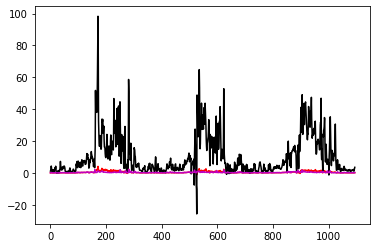

In [27]:
#%matplotlib 
DataSim1['surface_evaporation_T'] = DataSim1['surface-evaporation-trough']
DataSim1['surface_evaporation_C'] = DataSim1['surface-evaporation-center']
DataSim1['surface_evaporation_R'] = DataSim1['surface-evaporation-rim']

DataSim2['surface_evaporation_T'] = DataSim2['surface-evaporation-trough']
DataSim2['surface_evaporation_C'] = DataSim2['surface-evaporation-center']
DataSim2['surface_evaporation_R'] = DataSim2['surface-evaporation-rim']
#Evaporative flux
def local_axes():
    plt.xlabel('Year')
    #ax.set_xlim((2012.7, 2014.5))
    plt.ylim((-2, 8.0))
    #plt.legend(loc='upper left',fontsize=6)

open_water, mosses, bare_g= 0.15,0.37,0.48
Volume = [2.54729, 0.104032, 2.06396] # Trough, center, rim
ET1_Tr = [ d1*1000*86400/Volume[0] for d1 in DataSim1['surface_evaporation_T'] ]
ET1_C = [ d1*1000*86400/Volume[1] for d1 in DataSim1['surface_evaporation_C'] ]
ET1_R = [ d1*1000*86400/Volume[2] for d1 in DataSim1['surface_evaporation_R'] ]

plt.plot(ET1_Tr,'r')
plt.plot(ET1_C,'k')
plt.plot(ET1_R,'m')
plt.show()
ET1_Total = [open_water*x + mosses*y + bare_g*z for x,y,z in zip(ET1_Tr, ET1_C,ET1_R)]

ET2_Tr = [ d1*1000*86400 for d1 in DataSim2['surface_evaporation_T'] ]
ET2_C = [ d1*1000*86400 for d1 in DataSim2['surface_evaporation_C'] ]
ET2_R = [ d1*1000*86400 for d1 in DataSim2['surface_evaporation_R'] ]

ET2_Total = [open_water*x + mosses*y + bare_g*z for x,y,z in zip(ET2_Tr, ET2_C,ET2_R)]


#----------------------------------------------------------------------
def plot_EvaporativeFlux(location = 'trough'):
    fig, axs = plt.subplots(1,1, figsize=(6,4), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1]})
    fig.subplots_adjust(hspace =.02, wspace=1.02)

    plt.tight_layout()
    #axs = axs.ravel()
    
    lambda1 , lambda2 = 1,1
    Elev_T, Elev_R, Elev_C = 4.65873, 5.00137, 4.78591
    ax = plt.subplot(111)
    days_et = 315 + 205
    
    #plt.plot(DataSim2['Time'],ET1_Total,'k',label='Simulated')
    plt.plot(DataSim2['Time'],ET2_Total,'k',label='Simulated')
    plt.plot(ObservedET['Time'],ObservedET['ET'],'r.',label='Observed')
    
    ax.set_ylabel('Evaporation [mm/day]')
    ax.set_xlabel('Year')
    plt.xlim((2013.4, 2014.9))
    plt.ylim((0, 7))
    
    plt.legend(loc='upper left',fontsize=9)
    
    
    #plt.legend(loc='upper right', fontsize=10, ncol=3, bbox_to_anchor=(0.9,-0.3, .1, .1))
    plt.tight_layout()
    #plt.savefig(outfile+'ET-%s.pdf'%simulation[0], bbox_inches='tight', dpi=600)

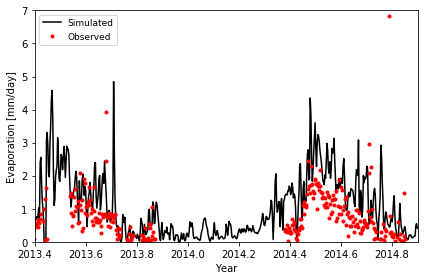

In [28]:
plot_EvaporativeFlux()

In [23]:


DataSim1['surface_evaporation_T'] = DataSim1['surface-evaporation-trough']
DataSim1['surface_evaporation_C'] = DataSim1['surface-evaporation-center']
DataSim1['surface_evaporation_R'] = DataSim1['surface-evaporation-rim']

def plot_EvaporativeFluxSimulatedOnly():
    fig, axs = plt.subplots(3,1, figsize=(5,6), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1]})
    fig.subplots_adjust(hspace =.02, wspace=1.02)

    plt.tight_layout()
    axs = axs.ravel()
    
    lambda1 , lambda2 = 1,1
    Elev_T, Elev_R, Elev_C = 4.65873, 5.00137, 4.78591
    ax = plt.subplot(311)
    days_et = 315 + 205
    
    Volume = [2.54729, 0.104032, 2.06396] # Trough, center, rim
    Sim1_T = [ d1*1000*86400 for d1 in DataSim1['surface_evaporation_T'] ]
       
    plt.plot(DataSim2['Time'][::1], Sim1_T[::1],'k.',label='Trough') 
    ax.set_ylabel('Evaporation [mm/day]')
    plt.legend(loc='upper right',fontsize=9)
    plt.ylim((0, 10))
    plt.xlim((2012, 2015))
    ax = plt.subplot(312)
       
    
    Sim1_C = [ d1*1000*86400 for d1 in DataSim2['surface_evaporation_C'] ]
    plt.plot(DataSim2['Time'][::1], Sim1_C[::1],'k.',label='Center')
    ax.set_ylabel('Evaporation [mm/day]')
    plt.ylim((0, 10))
    plt.xlim((2012, 2015))
    plt.legend(loc='upper right',fontsize=9)

    #local_axes()
    ax = plt.subplot(313)

    Sim1_R = [ d1*1000*86400 for d1 in DataSim2['surface_evaporation_R'] ]
    plt.plot(DataSim2['Time'][::1], Sim1_R[::1],'k.',label='Rim')
    #ax.set_title('Rim',fontweight='bold')
    ax.set_ylabel('Evaporation [mm/day]')
    ax.set_xlabel('Year')
    plt.ylim((0, 10))
    plt.xlim((2012, 2015))
    #local_axes()
    
    plt.legend(loc='upper right',fontsize=9)
    
    
    #plt.legend(loc='upper right', fontsize=10, ncol=3, bbox_to_anchor=(0.9,-0.3, .1, .1))
    plt.tight_layout()
    #plt.savefig(outfile+'%s-ET-micro-locations.pdf'%simulation[0], bbox_inches='tight', dpi=600)

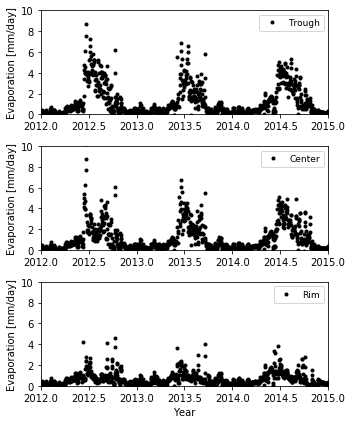

In [24]:
 plot_EvaporativeFluxSimulatedOnly()